In [ ]:
!pip install langchain==0.3.7
!pip install langchain-community==0.2.4
!pip install langchain-core==0.3.15
!pip install langchain-openai==0.2.5
!pip install langchain-text-splitters==0.3.2
!pip install langchain-chroma==0.1.4
!pip install matplotlib
!pip install pillow

In [1]:
import base64
import json
import os
import os.path
import re
import sys
import zipfile
from datetime import datetime

import openpyxl
import pandas as pd

sys.path.append("..")

import uuid
from mimetypes import guess_type
from typing import Dict, List, Optional

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from openai import OpenAI

from function.pdf_loader import *
from function.process_image import *

openai_api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()
# Initialize embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=openai_api_key)

### Testing

In [2]:
# test:
base_dir = "../data/processed/good_figures"
# pdf_names = os.listdir('../data/processed/good_figures')
pdf_names = ["The Athenaeum_Wedding Information_2024-2025"]
if __name__ == "__main__":
    try:
        for pdf_name in pdf_names:
            image_descriptions = generate_image_descriptions(
                base_dir=base_dir,
                venue=venue,
            )
            print(f"Successfully processed {len(descriptions)} images")
    except Exception as e:
        print(f"Error in main execution: {e}")

Error in main execution: name 'venue' is not defined


In [25]:
json_file_path = "../data/processed/description.json"
try:
    with open(json_file_path, "r") as file:
        image_description = json.load(file)
except Exception as e:
    f"Error reading the JSON file: {e}"
image_description

[{'image_path': '../data/processed/good_figures/_2024 Weddings at Lake Arrowhead~-merged/fileoutpart15.png',
  'description': 'The image showcases a wedding ceremony setup at an outdoor venue. It features a wooden arch decorated with flowers and greenery, overlooking a scenic view of a lake'},
 {'image_path': '../data/processed/good_figures/_2024 Weddings at Lake Arrowhead~-merged/fileoutpart13.png',
  'description': 'A couple is standing in a forested area with sunlight filtering through the trees, creating a serene and romantic atmosphere. They are facing each other, surrounded'}]

In [26]:
# Create vectorstore for summaries
vectorstore = Chroma(collection_name="image_summaries", embedding_function=embeddings)

# Create storage for original data
store = InMemoryStore()
id_key = "image_id"

# Initialize the retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Process your description_data
image_ids = [str(uuid.uuid4()) for _ in image_description]

# Create summary documents
summary_docs = [
    Document(
        page_content=item["description"],
        metadata={id_key: image_ids[i], "image_path": item["image_path"]},
    )
    for i, item in enumerate(image_description)
]

# Add summaries to vectorstore
retriever.vectorstore.add_documents(summary_docs)

# Store original data
original_data = [(id_, item) for id_, item in zip(image_ids, image_description)]
retriever.docstore.mset(original_data)

In [27]:
similar_docs = retriever.invoke("wedding by the lake")[0]
similar_docs

{'image_path': '../data/processed/good_figures/_2024 Weddings at Lake Arrowhead~-merged/fileoutpart15.png',
 'description': 'The image showcases a wedding ceremony setup at an outdoor venue. It features a wooden arch decorated with flowers and greenery, overlooking a scenic view of a lake'}

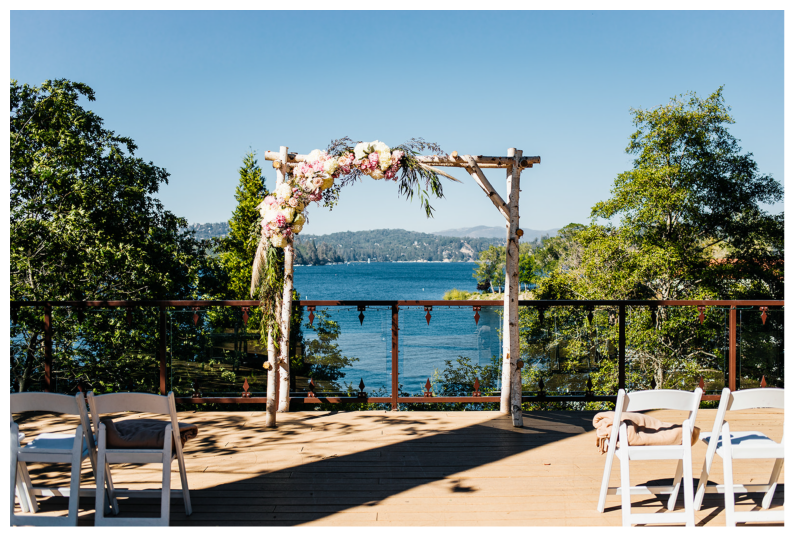


Text Response: A wedding by the lake can be a picturesque and serene setting, offering a beautiful backdrop for the ceremony. Here's an example description to help visualize the scene


In [28]:
import matplotlib.pyplot as plt
from PIL import Image


def text_and_image_query(
    query: str, context: dict, include_image: bool = True, display_image: bool = True
):
    # Get text response
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": query + "\n\nContext: " + context["description"],
                    }
                ],
            }
        ],
        max_tokens=30,
    )

    result = {
        "text_response": response.choices[0].message.content,
        "image_path": context["image_path"] if "image_path" in context else None,
    }

    # Display image if requested
    if display_image and result["image_path"]:
        try:
            im = Image.open(result["image_path"])
            plt.figure(figsize=(10, 8))
            plt.imshow(im)
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"Error displaying image: {e}")

    return result


# Usage example:
user_query = "How does a wedding by the lake look like? Show me an example"
similar_docs = retriever.invoke("wedding by the lake")[0]

# Get response and display image
response = text_and_image_query(
    query=user_query, context=similar_docs, display_image=True
)

print("\nText Response:", response["text_response"])

In [10]:
import glob

df_result = pd.DataFrame()
output_base_zip_path = "../data/processed/adobe_result/"
all_files = glob.glob("../data/processed/adobe_result/*")
to_run_file = [os.path.join(output_base_zip_path, file) for file in all_files]
output_base_extract_folder = "../data/processed/adobe_extracted/"
to_run_file = [
    "../data/processed/adobe_result/_2024 Weddings at Lake Arrowhead~-merged"
]
for pdf_path in to_run_file:
    pdf_name = os.path.basename(pdf_path).replace(".pdf", "")
    output_zip_path = os.path.join(output_base_zip_path, pdf_name, f"sdk.zip")
    output_zipextract_folder = os.path.join(output_base_extract_folder, pdf_name)
    df = extract_text_from_file_adobe(output_zip_path, output_zipextract_folder)
    df["company"] = pdf_name
    df = df.groupby("company")["text"].apply(lambda x: "\n".join(x)).reset_index()
    df_result = pd.concat([df_result, df], ignore_index=True)

2024-11-24 23:00:10 JSON file already exists. Skipping extraction.
2024-11-24 23:00:10 open json file
2024-11-24 23:00:10 extract text


### Actual pipeline

2024-11-25 00:18:39 JSON file already exists. Skipping extraction.
2024-11-25 00:18:39 open json file
2024-11-25 00:18:39 extract text
Company: _2024 Weddings at Lake Arrowhead~-merged
Image Description: A beautifully decorated outdoor wedding altar overlooking a picturesque lake, surrounded by lush trees and clear blue skies.


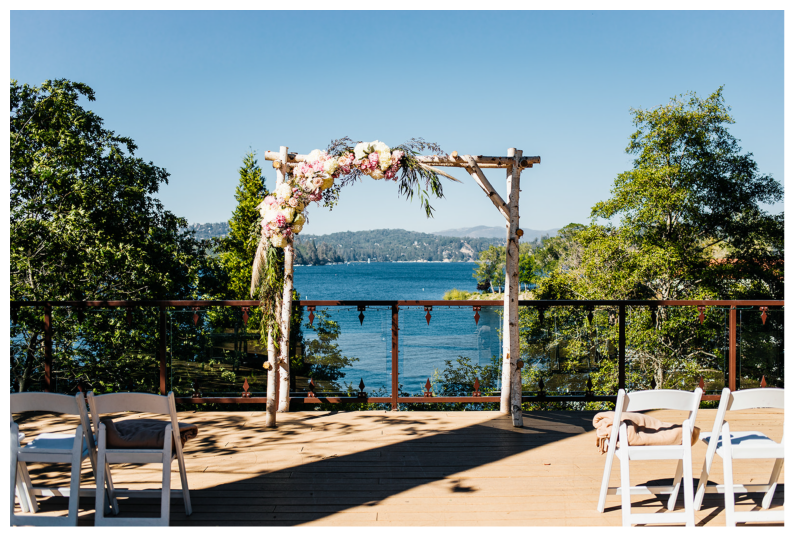

In [24]:
import matplotlib.pyplot as plt
from PIL import Image


def process_multiple_pdfs_to_retriever():
    # Initialize retriever
    vectorstore = Chroma(
        collection_name="multimodal_docs", embedding_function=embeddings
    )
    store = InMemoryStore()
    id_key = "content_id"

    retriever = MultiVectorRetriever(
        vectorstore=vectorstore, docstore=store, id_key=id_key, search_kwargs={}
    )
    all_files = [
        "../data/processed/adobe_result/_2024 Weddings at Lake Arrowhead~-merged"
    ]

    # process all PDFs
    for pdf_path in all_files:
        pdf_name = os.path.basename(pdf_path).replace(".pdf", "")
        doc_id = str(uuid.uuid4())  # One ID per PDF
        output_base_zip_path = "../data/processed/adobe_result/"
        output_base_extract_folder = "../data/processed/adobe_extracted/"

        # Process text content
        output_zip_path = os.path.join(output_base_zip_path, pdf_name, f"sdk.zip")
        output_zipextract_folder = os.path.join(output_base_extract_folder, pdf_name)

        df = extract_text_from_file_adobe(output_zip_path, output_zipextract_folder)
        df["company"] = pdf_name
        text_content = (
            df.groupby("company")["text"].apply(lambda x: "\n".join(x)).reset_index()
        )

        # Create text documents
        text_ids = [f"{doc_id}_text_{i}" for i in range(len(text_content))]
        text_docs = [
            Document(
                page_content=row["text"],
                metadata={
                    id_key: text_ids[i],
                    "doc_id": doc_id,
                    "company": row["company"],
                    "type": "text",
                },
            )
            for i, row in text_content.iterrows()
        ]

        # Process images if they exist
        output_goodimages_folder = "../data/processed/good_figures/"
        try:
            # Generate image descriptions
            image_descriptions = generate_image_descriptions(
                base_dir=output_goodimages_folder,
                pdf_name=pdf_name,
                output_file=os.path.join(
                    output_base_extract_folder, f"{pdf_name}_descriptions.json"
                ),
            )

            # Create image documents
            image_ids = [f"{doc_id}_image_{i}" for i in range(len(image_descriptions))]
            image_docs = [
                Document(
                    page_content=item["description"],
                    metadata={
                        id_key: image_ids[i],
                        "doc_id": doc_id,
                        "company": pdf_name,
                        "type": "image",
                        "image_path": item["image_path"],
                    },
                )
                for i, item in enumerate(image_descriptions)
            ]
        except Exception as e:
            print(f"Error processing images for {pdf_name}: {e}")
            continue

        # Add all documents to vectorstore
        all_docs = text_docs + image_docs
        retriever.vectorstore.add_documents(all_docs)

        # Store original data
        original_data = [(doc.metadata[id_key], doc) for doc in all_docs]
        retriever.docstore.mset(original_data)

    return retriever


def query_documents(retriever, query):
    # Get similar documents
    similar_docs = retriever.invoke(query)

    # Group by document
    results = {}
    for doc in similar_docs:
        doc_id = doc.metadata["doc_id"]
        if doc_id not in results:
            results[doc_id] = {
                "company": doc.metadata["company"],
                "text": [],
                "images": [],
            }

        if doc.metadata["type"] == "text":
            results[doc_id]["text"].append(doc)
        else:
            results[doc_id]["images"].append(doc)
    # Display result
    for doc_id, content in results.items():
        print(f"Company: {content['company']}")

        # Display text content
        for text_doc in content["text"]:
            print(f"Text: {text_doc.page_content}\n")

        # Display image content and images
        for image_doc in content["images"]:
            image_path = image_doc.metadata.get("image_path")
            description = image_doc.page_content
            print(f"Image Description: {description}")
            if image_path:
                try:
                    im = Image.open(image_path)
                    plt.figure(figsize=(10, 8))
                    plt.imshow(im)
                    plt.axis("off")
                    plt.show()
                except Exception as e:
                    print(f"Error displaying image: {e}")

    return results


# Example usage:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=openai_api_key)
retriever = process_multiple_pdfs_to_retriever()
results = query_documents(retriever, "wedding by the lake")


In [26]:
# Print results
for doc_id, content in results.items():
    print(f"\nCompany: {content['company']}")
    if content["text"]:
        print("\nText Content:")
        for text in content["text"]:
            print(f"- {text.page_content[:200]}...")
    if content["images"]:
        print("\nRelated Images:")
        for image in content["images"]:
            print(f"- {image.metadata['image_path']}")
            print(f"  Description: {image.page_content}")


Company: _2024 Weddings at Lake Arrowhead~-merged

Related Images:
- ../data/processed/good_figures/_2024 Weddings at Lake Arrowhead~-merged/fileoutpart15.png
  Description: A beautifully decorated outdoor wedding altar overlooking a picturesque lake, surrounded by lush trees and clear blue skies.


In [28]:
results

{'e1662d6b-c9b0-4f0c-90a7-39bb7781a02e': {'company': '_2024 Weddings at Lake Arrowhead~-merged',
  'text': [],
  'images': [Document(metadata={'content_id': 'e1662d6b-c9b0-4f0c-90a7-39bb7781a02e_image_0', 'doc_id': 'e1662d6b-c9b0-4f0c-90a7-39bb7781a02e', 'company': '_2024 Weddings at Lake Arrowhead~-merged', 'type': 'image', 'image_path': '../data/processed/good_figures/_2024 Weddings at Lake Arrowhead~-merged/fileoutpart15.png'}, page_content='A beautifully decorated outdoor wedding altar overlooking a picturesque lake, surrounded by lush trees and clear blue skies.')]}}

In [2]:
import sys

sys.path.append("..")
from function.retriever import *

/Users/lanchu/mambaforge/envs/wedding-venue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-18 23:41:50.230 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-18 23:41:50.232 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [3]:
import re

from google.cloud import storage


def list_main_folders(bucket_name, filter=None):
    if filter is not None:
        filter = re.compile(filter, re.IGNORECASE)

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs()

    # Collect only primary folders (ignoring deeper paths like "figures" or "tables")
    main_folders = set()
    for blob in blobs:
        if "/" in blob.name:  # Check for folder-like structure
            folder_path = "/".join(blob.name.split("/")[:-1])  # Exclude the file itself
            if filter is None or filter.search(folder_path):
                # Only include top-level folders (filter out deeper paths)
                if not any(
                    folder_path.endswith(extra) for extra in ["/figures", "/tables"]
                ):
                    main_folders.add(folder_path)

    return sorted(main_folders)  # Return sorted folder names


# Example usage
bucket_name = "wedding-venues-001"
folders = list_main_folders(bucket_name=bucket_name, filter="venues/")
len(folders)


280

In [6]:
import io
import os
import re
import sys
import time
from pathlib import Path
from tempfile import NamedTemporaryFile
from typing import Dict, List
from zipfile import ZipFile

import pandas as pd
from dotenv import load_dotenv
from google.cloud import storage
from google.cloud.storage import Client, transfer_manager

sys.path.append("..")
from function.pdf_loader import *

load_dotenv()


def list_files(bucket_name, filter=None):
    if filter is not None:
        filter = re.compile(filter, re.IGNORECASE)

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blobs = bucket.list_blobs()
    return [blob.name for blob in blobs if filter is None or filter.search(blob.name)]


def download_file(bucket_name: str, source_blob_name: str, destination_file_name: str):
    os.makedirs(os.path.dirname(destination_file_name), exist_ok=True)

    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)
    return destination_file_name


def download_files(bucket_name: str, files: list[str]):
    client = Client()
    bucket = client.bucket(bucket_name)

    # Create download objects
    downloads = [(bucket.blob(file_name), file_name) for file_name in files]

    # Make sure directories exist
    for _, dest_path in downloads:
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)

    # Use transfer_manager to download files in parallel
    results = transfer_manager.download_many(
        downloads,
        max_workers=10,  # adjust number of workers as needed
    )

    return results


def get_pdf_paths(bucket_name: str = "wedding-venues-001") -> List[Path]:
    """
    Get PDF paths from Google Cloud Storage using existing cloud functions.

    Args:
        bucket_name (str): Name of the GCS bucket

    Returns:
        List[Path]: List of paths to downloaded PDFs
    """
    # Use your existing list_files function with the venues filter
    pdf_files = list_files(bucket_name, filter="venues/.*\.pdf$")

    # Download all PDFs using your existing download_files function
    results = download_files(bucket_name, pdf_files)

    # Convert to Path objects
    pdf_paths = [Path(pdf_file) for pdf_file in pdf_files]

    return pdf_paths


PDF_PATHS = get_pdf_paths()

In [9]:
len(PDF_PATHS)

280

In [12]:
import streamlit as st

st.session_state["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

2024-12-19 01:23:05.230 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 01:23:05.231 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [15]:
import os
from pathlib import Path

from dotenv import load_dotenv

from function.retriever import initialize_retriever, update_retriever


def update_retriever(retriever: MultiVectorRetriever) -> None:
    """
    Update the retriever by adding new PDFs and removing deleted ones.

    Parameters
    ----------
    retriever : MultiVectorRetriever
        The retriever to update.
    """
    metadatas = [
        entry.metadata for entry in retriever.vectorstore.docstore._dict.values()
    ]
    all_stored_companies = set(_["company"] for _ in metadatas)

    all_companies = set(
        path.name.replace(".pdf", "") for path in PDF_PATH.glob("*.pdf")
    )

    new_pdfs = all_companies - all_stored_companies
    deleted_pdfs = all_stored_companies - all_companies

    add_pdfs_to_retriever(new_pdfs, retriever)
    # remove_pdfs_from_retriever(deleted_pdfs, retriever)
    retriever.vectorstore.save_local(PERSIST_DIRECTORY)
    if new_pdfs or deleted_pdfs:
        print(f"all pdfs in {PDF_PATH}: {all_companies}")
        print(f"all pdfs in database: {all_stored_companies}")
        print(f"new pdfs: {new_pdfs}")
        print(f"deleted pdfs: {deleted_pdfs}")

In [16]:
def preprocess_documents(pdf_paths: Iterable[str | Path]) -> dict[str, dict[str, Any]]:
    """
    Preprocess PDFs by extracting text and generating image descriptions.

    Parameters
    ----------
    pdf_paths : Iterable[str | Path]
        Collection of PDF file paths to process.

    Returns
    -------
    Dict[str, Dict[str, Any]]
        Dictionary containing preprocessed document information including text content
        and image descriptions.
    """
    BUCKET_NAME = "wedding-venues-001"

    try:
        # Get all files from processed folders
        output_base_zip_path = Path("data/processed/adobe_result/")
        adobe_extracted_files = list_files(
            BUCKET_NAME, filter="processed/adobe_extracted/.*"
        )

        # Download all files, maintaining directory structure
        # download_files(BUCKET_NAME, adobe_result_files)
        download_files(BUCKET_NAME, adobe_extracted_files)

    except Exception as e:
        print(f"Error downloading files from GCS: {e}")
        raise

    new_documents: dict[str, dict[str, Any]] = {}

    for pdf_path in stqdm(pdf_paths):
        print(f"processing {pdf_path}")
        pdf_name = os.path.basename(pdf_path).replace(".pdf", "")
        output_zip_path = os.path.join(output_base_zip_path, pdf_name, "sdk.zip")
        output_zipextract_folder = os.path.join(output_base_extract_folder, pdf_name)
        client_id = os.getenv("ADOBE_CLIENT_ID")
        client_secret = os.getenv("ADOBE_CLIENT_SECRET")
        if not os.path.exists(
            os.path.join(output_zipextract_folder, "structuredData.json")
        ):
            print(f"loading {pdf_name} to adobe pdf services...")
            adobeLoader(
                pdf_path,
                output_zip_path=output_zip_path,
                client_id=client_id,
                client_secret=client_secret,
            )
        df = extract_text_from_file_adobe(output_zip_path, output_zipextract_folder)
        df["company"] = pdf_name
        text_content = (
            df.groupby("company")["text"].apply(lambda x: "\n".join(x)).reset_index()
        )
        extracted_figure_folder = Path(output_zipextract_folder) / "figures"
        if not extracted_figure_folder.exists():
            image_descriptions = []
        else:
            image_descriptions = generate_image_descriptions(
                base_dir=extracted_figure_folder,
                pdf_name=pdf_name,
                output_file=os.path.join(
                    output_base_extract_folder, f"{pdf_name}_descriptions.json"
                ),
            )

        doc_id = str(uuid.uuid4())

        document_info = {
            "doc_id": doc_id,
            "text_content": text_content.to_dict("records"),
            "image_descriptions": image_descriptions,
        }

        new_documents[pdf_name] = document_info

    return new_documents


In [1]:
import os
import sys

sys.path.append("..")

from dotenv import load_dotenv, find_dotenv

from function.retriever import initialize_retriever, update_retriever

load_dotenv(override=True)

path = find_dotenv()
PROJECT_ROOT = os.path.dirname(path)
PERSIST_DIRECTORY = os.path.join(PROJECT_ROOT, os.getenv("DATABASE_DIR"))
os.makedirs(PERSIST_DIRECTORY, exist_ok=True)

try:
    retriever = initialize_retriever()
    update_retriever(retriever)
    print("Retriever initialized successfully!")
except Exception as e:
    print(f"Error initializing retriever: {e}")

/Users/lanchu/mambaforge/envs/wedding-venue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-19 02:07:34.033 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-12-19 02:07:34.034 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


Loaded existing FAISS index from faiss_db


2024-12-19 02:07:34.140 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 02:07:34.374 
  command:

    streamlit run /Users/lanchu/mambaforge/envs/wedding-venue/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-19 02:07:34.374 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 02:07:34.376 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 02:07:34.376 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 02:07:34.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 02:07:34.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-19 02:07:

processing venues/The Crossings at Carlsbad.pdf
loading The Crossings at Carlsbad to adobe pdf services...
Error initializing retriever: [Errno 2] No such file or directory: 'venues/The Crossings at Carlsbad.pdf'
